In [118]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os



## Connect to SNAP2 boards

In [119]:
brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']

#connect through Jack's fengine etcd interface for everything that can go through etcd
snapbrds = [snap2_fengine.Snap2FengineEtcd(brdname).fpga for brdname in brdnames]  
fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c.fpg'


2024-03-28 20:32:25,676 - lwa_f.blocks.block:snap01 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,683 - lwa_f.blocks.block:snap02 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,802 - lwa_f.blocks.block:snap03 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,808 - lwa_f.blocks.block:snap04 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,813 - lwa_f.blocks.block:snap05 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,818 - lwa_f.blocks.block:snap06 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,823 - lwa_f.blocks.block:snap07 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,828 - lwa_f.blocks.block:snap08 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-03-28 20:32:25,833 - lwa_f.blocks.block:snap09 - INFO - eth - Couldn't find Ethernet core. 

## Completely reset trigger on all boards to make sure there aren't already trigger and veto settings

In [124]:


veto_roles_array=np.zeros(64,dtype=int)
core_roles_array=np.zeros(64,dtype=int)
for p in range(11):
    snapbrd=snapbrds[p]
    setup_coincidencer(snapbrd,0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          core_roles_array,
                          veto_roles_array)
    setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0)


## Set up ethernet and send a test snapshot
Ethernet setup doesn't go through etcd yet.

In [125]:
#connect to the SNAP2s with casperfpga since some functions (ethernet setup) doesn't go through etcd yet
casperbrds = [casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport) for brdname in brdnames]


In [126]:
computer='gpu09' # 'lwacr' or 'gpu09'
packetwait=100 #clock cycles between packets
wait_after_readout=200 #time [clock cycles] to wait for other boards to finish readout
for i,brdname in enumerate(brdnames):
    casperbrd=casperbrds[i]
    #prepare to send a snapshot
    
    setup_data_source(casperbrd,"adc") #set the data source to ADC
    setup_ethernet(brdname,casperbrd,fpgfile,computer,packetwait) #set up the ethernet packetizer and ethernet block
    setvalue(casperbrd,'wait_after_readout','cr_registers.xlsx',wait_after_readout) #set the wait time after readout before new internally-generated triggers are accepted
    setvalue(casperbrd,'brd_id','cr_registers.xlsx',int(brdname[-2:])) #set the board id
    setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)  #enable ethernet

Data source set to adc
------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap02:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:02:02:02
Gateway:  0.0.0.1
IP:  10.41.0.202
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap03:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:03:03:03
Gateway:  0.0.0.1
IP:  10.41.0.203
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips:

In [127]:
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]

#send trigger to just one board and all will send packets
software_trigger(snapbrds[3],1)

Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 137669 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


## Run Trigger 

In [134]:
#configure trigger
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]


current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2024-2-21.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2024-2-21.npy')


ok_snaps=[0,1,2,3,4,5,6,7,8,9,10] #zero indexed
#set up coincidencer
trigger_power_thresh=150**2
veto_power_thresh=100**2
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
antenna_number_thresh=7
veto_number_thresh=63

bufferwait=2000

for b in ok_snaps:
    snapbrd=snapbrds[b]
    veto_roles_array=current_ok_vetos[b,:]
    core_roles_array=current_ok_core[b,:]

    setup_coincidencer(snapbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)
    setvalue(snapbrd,"delay_trigger","cr_registers.xlsx",bufferwait)



In [135]:
#set trigger on or off
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds] 

[None, None, None, None, None, None, None, None, None, None, None]

In [136]:
#send a test trigger to check that settings are applied correctly

#send trigger to just one board and all will send packets
software_trigger(snapbrds[3],1)

Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 137669 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


## Run Rate Monitor

In [112]:
%%capture output
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",1) for snapbrd in snapbrds] 

now=time.time()
duration=12*60*60 #in seconds
finish=now+duration
waittime=30

core_triggers=np.zeros((11,int(duration/waittime)))
veto_triggers=np.zeros((11,int(duration/waittime)))
core_cycles=np.zeros((11,int(duration/waittime)))
veto_cycles=np.zeros((11,int(duration/waittime)))
successful_triggers=np.zeros((11,int(duration/waittime)))
readout_dones=np.zeros((11,int(duration/waittime)))


i=0

time.sleep(waittime)
while time.time()<finish:
    for b in ok_snaps:
        snapbrd=snapbrds[b]
        veto_coincidence,core_coincidence=snapbrd.read_list_from_ram("cosmic_ray_core_and_veto_rate",2,'u4')
        veto_total_cycles,core_total_cycles=snapbrd.read_list_from_ram("cosmic_ray_core_n_veto_tot_clk_cycles",2,'u4')
        readout_done,successful_trigger=snapbrd.read_list_from_ram("cosmic_ray_core_n_veto_tot_clk_cycles1",2,'u4')
        core_triggers[b,i]=core_coincidence            
        veto_triggers[b,i]=veto_coincidence
        core_cycles[b,i]=core_total_cycles
        veto_cycles[b,i]=veto_total_cycles
        successful_triggers[b,i]=successful_trigger
        readout_dones[b,i]=readout_done
    time.sleep(waittime)
    i+=1
                                                                             


#[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",1) for snapbrd in snapbrds]


Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'
Command status from FID 1 returned: 'error'


TypeError: unsupported operand type(s) for &: 'NoneType' and 'int'

In [116]:
print(np.max(core_triggers))

216983.0


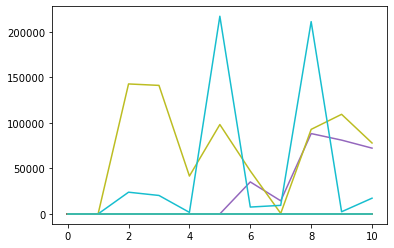

In [117]:
plt.plot(np.asarray(core_triggers))
plt.show()

In [115]:
output.show()

In [55]:
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]

[None, None, None, None, None, None, None, None, None, None, None]

In [56]:
#fname_prefix='/home/ubuntu/kp/data/testing/February27a'
#np.save(fname_prefix+'core',np.asarray(core_triggers))
#np.save(fname_prefix+'veto',np.asarray(veto_triggers))
#np.save(fname_prefix+'vetocycles',np.asarray(veto_cycles))
#np.save(fname_prefix+'corecycles',np.asarray(core_cycles))
#np.save(fname_prefix+'successfultrigger',np.asarray(successful_triggers))
#np.save(fname_prefix+'readoutdone',np.asarray(readout_dones))


In [57]:
print(i)

17


In [58]:
print(int(duration/waittime))
print(i,(i*waittime)/(60*60))

30
17 0.004722222222222222


## Note: if monitor crashed part way through, set xlim differently


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


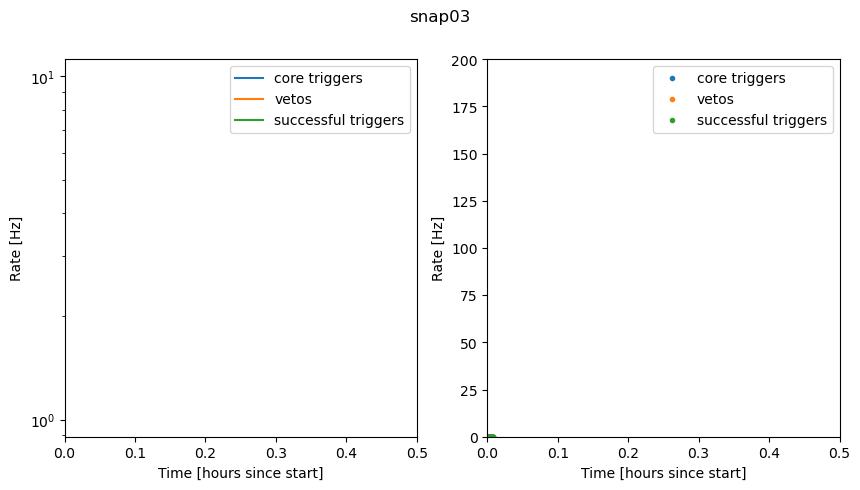

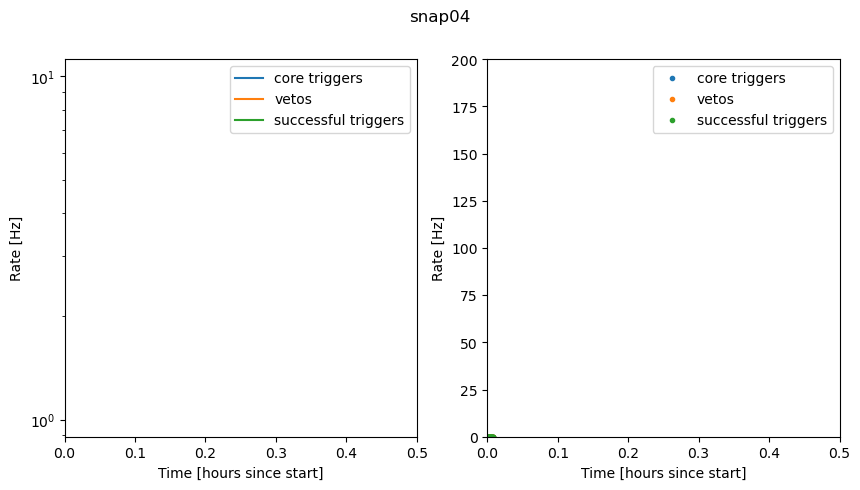

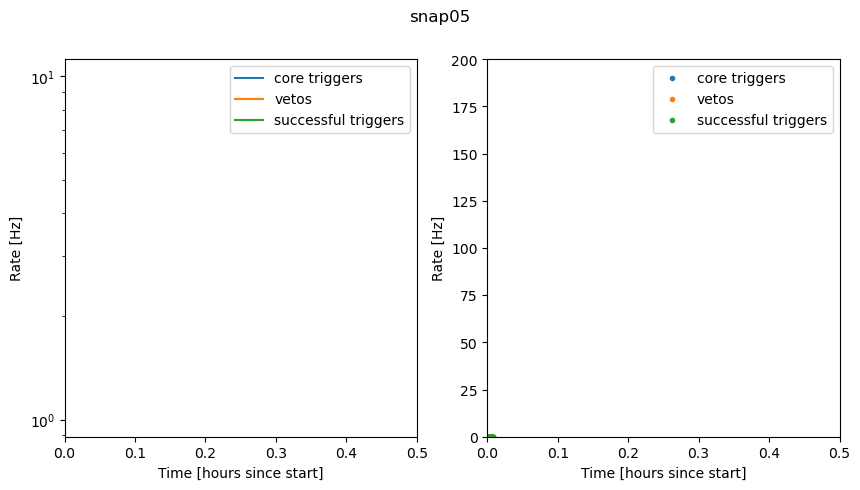

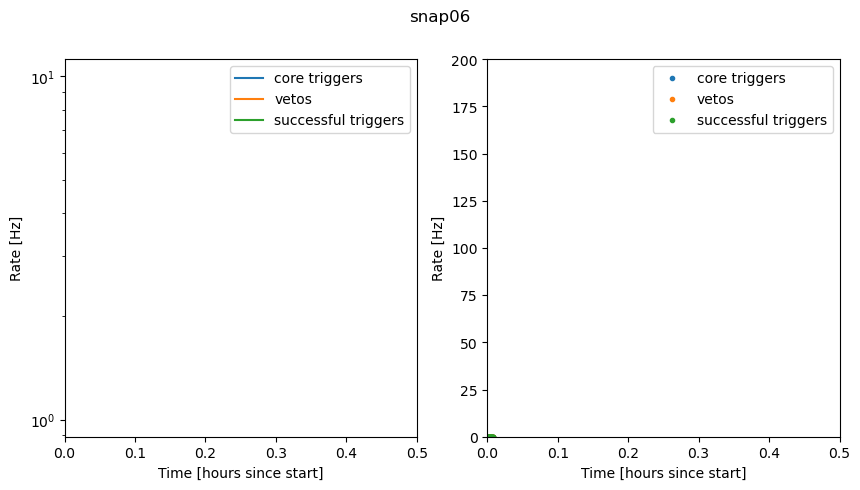

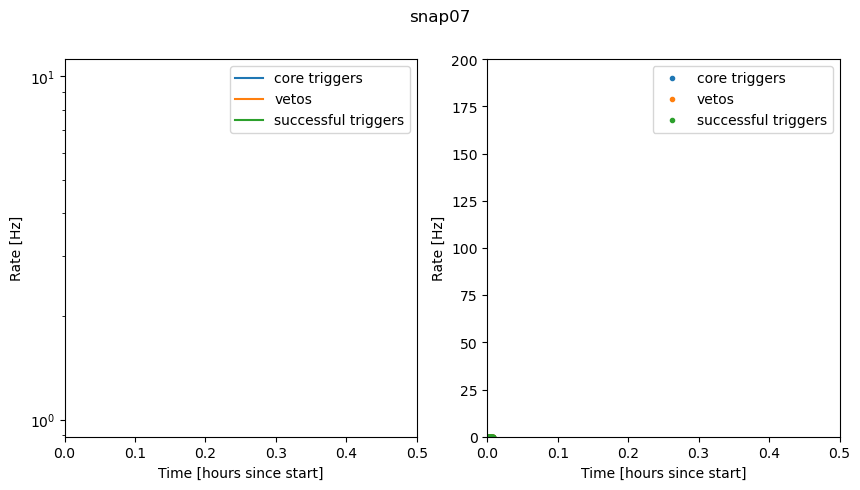

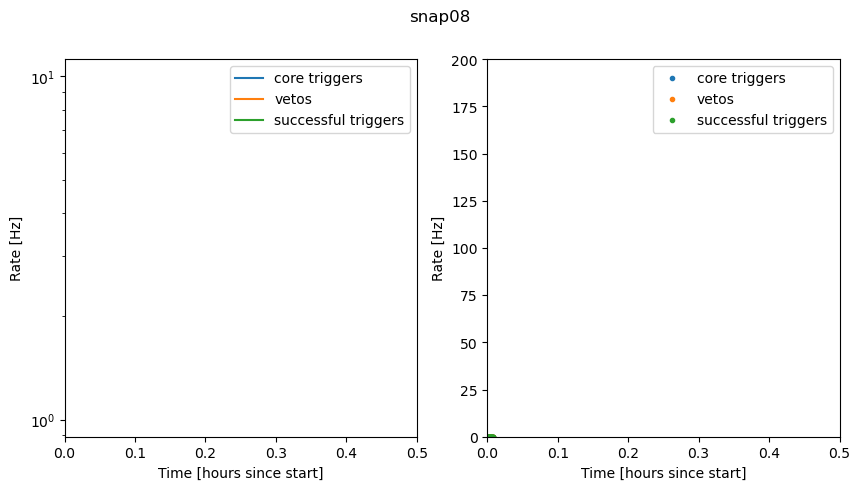

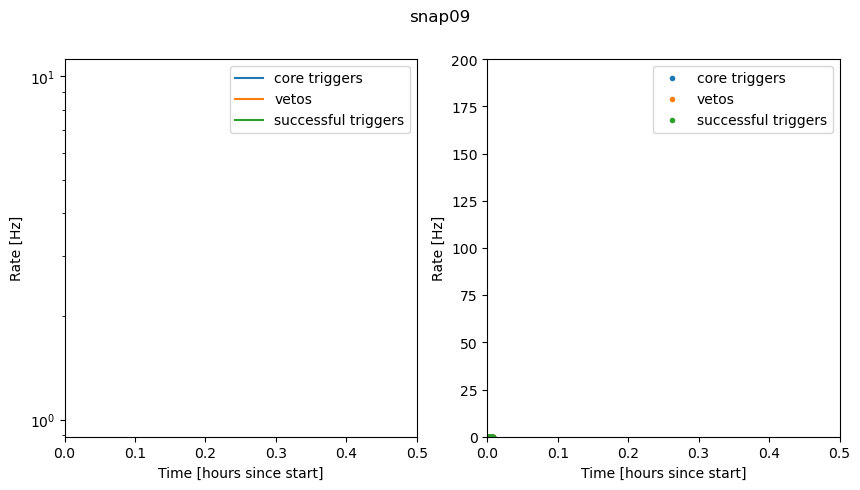

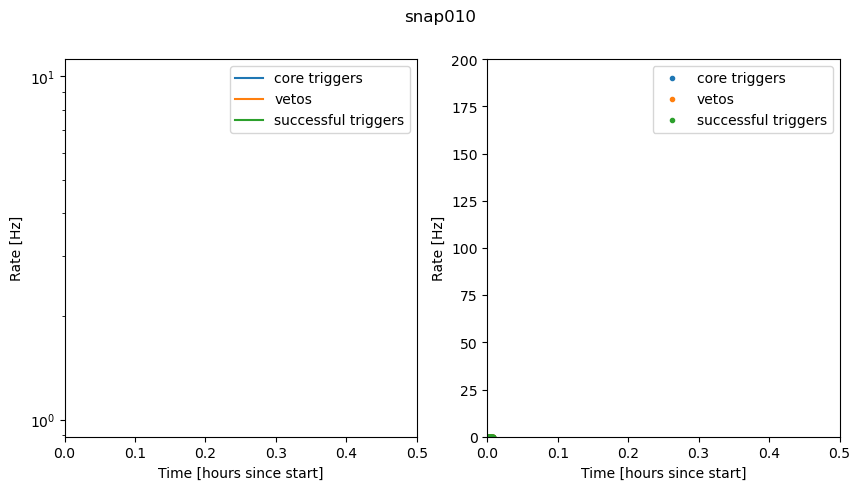

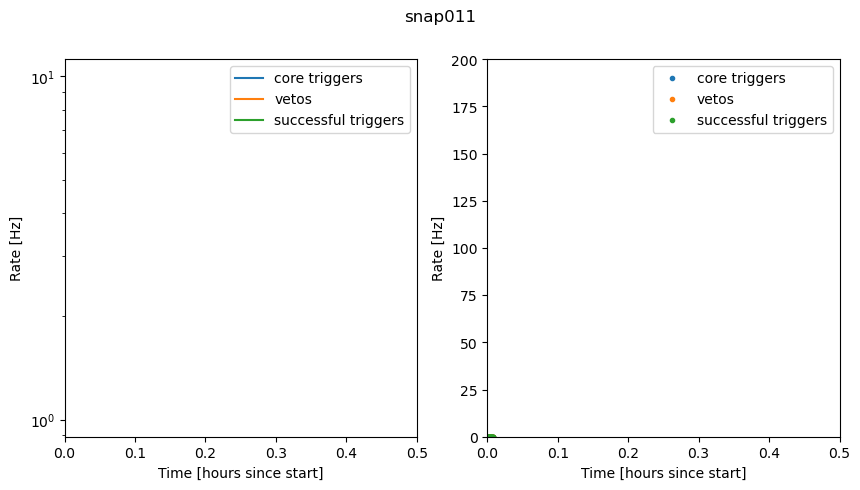

In [59]:


#fname_prefix='/home/ubuntu/kp/data/2023June20/overnight-'
ok_snaps=[2,3,4,5,6,7,8,9,10] #zero indexed

veto_all=(np.load(fname_prefix+'veto'+'.npy'))*0.73 #convert to Hz
core_all=(np.load(fname_prefix+'core'+'.npy'))*0.73 #convert to Hz

veto_cycles=np.load(fname_prefix+'vetocycles'+'.npy')
core_cycles=np.load(fname_prefix+'corecycles'+'.npy')

successful_triggers_all=np.load(fname_prefix+'successfultrigger'+'.npy')*0.73
readout_dones=np.load(fname_prefix+'readoutdone'+'.npy')*0.73


for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.figure(figsize=(10,5),dpi=100)
    plt.suptitle('snap0'+str(b+1))
    
    plt.subplot(121)
    plt.semilogy(timeaxis,core,label='core triggers')
    plt.semilogy(timeaxis,veto,label='vetos')
    plt.semilogy(timeaxis,successful_triggers,label='successful triggers')
    #plt.plot(timeaxis,readout_done,'.',label='readout')

    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.xlim(0,0.5)
    
    plt.subplot(122)
    plt.plot(timeaxis,core,'.',label='core triggers')
    plt.plot(timeaxis,veto,'.',label='vetos')
    plt.plot(timeaxis,successful_triggers,'.',label='successful triggers')
    #plt.plot(timeaxis,readout_done,'.',label='readout')
    plt.ylim(0,200)

    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.xlim(0,0.5)



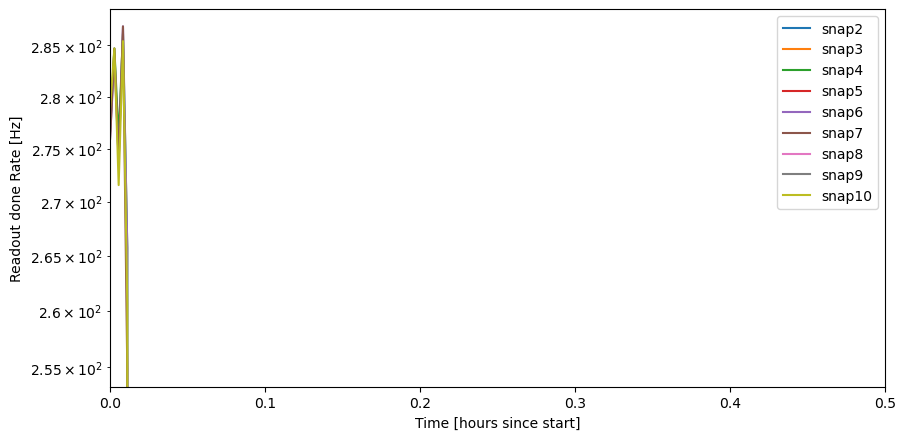

In [73]:
plt.figure(figsize=(10,5),dpi=100)
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.semilogy(timeaxis,readout_done,label='snap'+str(b))
    plt.ylabel("Readout done Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.xlim(0,0.5)
    #plt.ylim(0,200)

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubun

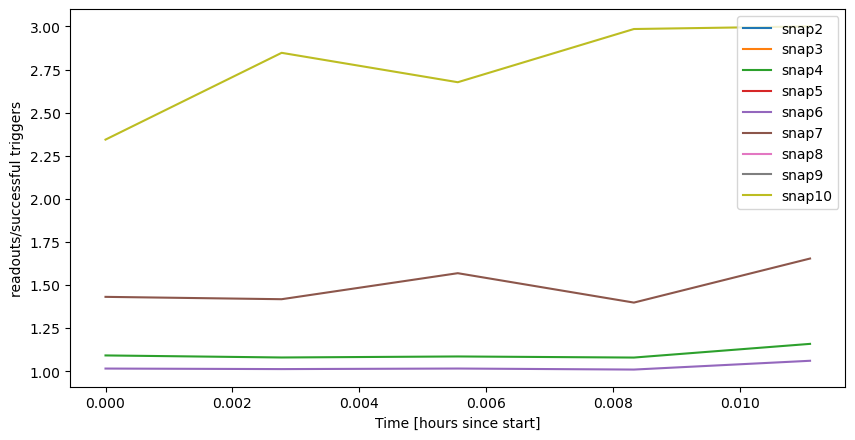

In [75]:
plt.figure(figsize=(10,5),dpi=100)
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,readout_done/successful_triggers,label='snap'+str(b))
    plt.ylabel("readouts/successful triggers")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    

Plot above shows ratio of readouts to successful triggers for each board.  A readout occurs whenever any board triggers, and so the readout rate can be larger than an individual board's trigger rate.  However, the ratio can also be less than one since triggers continue to be logged while the board is in readout state.

2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0005777825933363883
8 0.0
9 0.0
10 0.001917378984083902


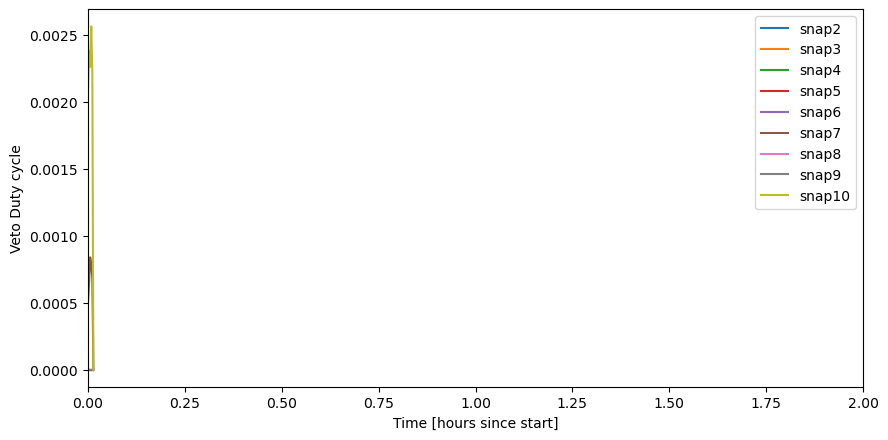

In [76]:
plt.figure(figsize=(10,5),dpi=100)
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,veto_cycle/((2**28)-1),label='snap'+str(b))
    plt.ylabel("Veto Duty cycle")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    #print('veto cycle')
    print(b,np.mean(veto_cycle)/((2**28)-1))
    #print('core cycle')
    #print(b,np.mean(core_cycle)/((2**28)-1))
    plt.xlim(0,2)

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0]

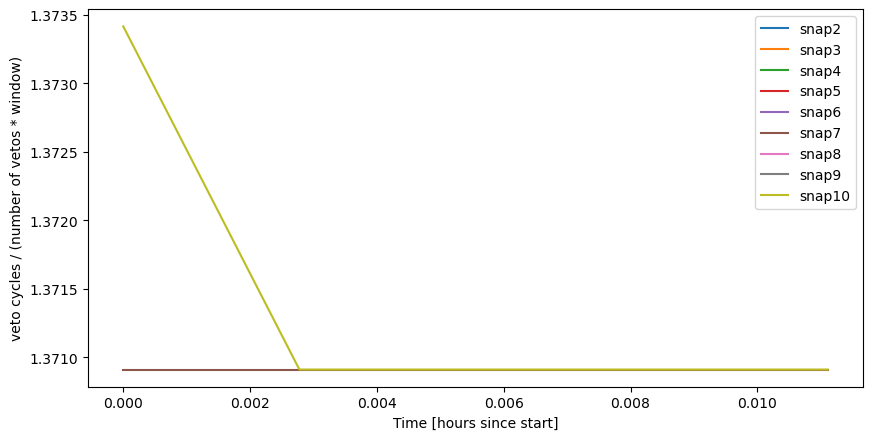

In [77]:
plt.figure(figsize=(10,5),dpi=100)
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,(veto_cycle/(2*veto_window*veto)),label='snap'+str(b))
    plt.ylabel("veto cycles / (number of vetos * window)")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    

I think there is a 10% chance the veto window is off by a factor of two.

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0]

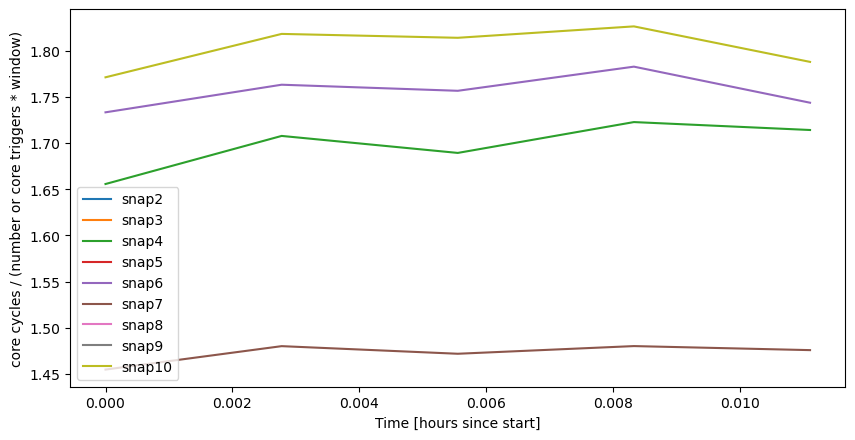

In [78]:
plt.figure(figsize=(10,5),dpi=100)
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,(core_cycle/(trigger_window*core)),label='snap'+str(b))
    plt.ylabel("core cycles / (number or core triggers * window)")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    

2024-02-22 19:35:00,889 - lwa_f.blocks.block:snap01 - WARNING - eth - Couldn't find Ethernet core. Will retry later


In [83]:
test.fpga.listdev()

['aaa_onegbe_one_GbE',
 'adc_sync',
 'ads5296_controller0_0',
 'ads5296_controller0_1',
 'ads5296_controller1_0',
 'ads5296_controller1_1',
 'ads5296_hardware_rst0',
 'ads5296_hardware_rst1',
 'ads5296_spi_controller0',
 'ads5296_spi_controller1',
 'ads5296_wb_ram0_0_0',
 'ads5296_wb_ram0_0_1',
 'ads5296_wb_ram0_0_2',
 'ads5296_wb_ram0_0_3',
 'ads5296_wb_ram0_1_0',
 'ads5296_wb_ram0_1_1',
 'ads5296_wb_ram0_1_2',
 'ads5296_wb_ram0_1_3',
 'ads5296_wb_ram1_0_0',
 'ads5296_wb_ram1_0_1',
 'ads5296_wb_ram1_0_2',
 'ads5296_wb_ram1_0_3',
 'ads5296_wb_ram1_1_0',
 'ads5296_wb_ram1_1_1',
 'ads5296_wb_ram1_1_2',
 'ads5296_wb_ram1_1_3',
 'autocorr_acc_cnt',
 'autocorr_acc_len',
 'autocorr_common_dout0_bram',
 'autocorr_common_dout1_bram',
 'autocorr_common_dout2_bram',
 'autocorr_common_dout3_bram',
 'autocorr_common_dout4_bram',
 'autocorr_common_dout5_bram',
 'autocorr_common_dout6_bram',
 'autocorr_common_dout7_bram',
 'autocorr_mux_sel',
 'autocorr_trig',
 'chan_reorder_dynamic_map1',
 'corr_0_

In [9]:
snapbrd.read_list_from_ram("cosmic_ray_core_n_veto_tot_clk_cycles",2,'u4')

[0, 0]

In [10]:
snapbrd.listdev()


['aaa_onegbe_one_GbE',
 'adc_sync',
 'ads5296_controller0_0',
 'ads5296_controller0_1',
 'ads5296_controller1_0',
 'ads5296_controller1_1',
 'ads5296_hardware_rst0',
 'ads5296_hardware_rst1',
 'ads5296_spi_controller0',
 'ads5296_spi_controller1',
 'ads5296_wb_ram0_0_0',
 'ads5296_wb_ram0_0_1',
 'ads5296_wb_ram0_0_2',
 'ads5296_wb_ram0_0_3',
 'ads5296_wb_ram0_1_0',
 'ads5296_wb_ram0_1_1',
 'ads5296_wb_ram0_1_2',
 'ads5296_wb_ram0_1_3',
 'ads5296_wb_ram1_0_0',
 'ads5296_wb_ram1_0_1',
 'ads5296_wb_ram1_0_2',
 'ads5296_wb_ram1_0_3',
 'ads5296_wb_ram1_1_0',
 'ads5296_wb_ram1_1_1',
 'ads5296_wb_ram1_1_2',
 'ads5296_wb_ram1_1_3',
 'autocorr_acc_cnt',
 'autocorr_acc_len',
 'autocorr_common_dout0_bram',
 'autocorr_common_dout1_bram',
 'autocorr_common_dout2_bram',
 'autocorr_common_dout3_bram',
 'autocorr_common_dout4_bram',
 'autocorr_common_dout5_bram',
 'autocorr_common_dout6_bram',
 'autocorr_common_dout7_bram',
 'autocorr_mux_sel',
 'autocorr_trig',
 'chan_reorder_dynamic_map1',
 'corr_0_

In [8]:
snapbrd=snapbrds[0]
snapbrd.read_list_from_ram("cosmic_ray_thresh_rate1", 32, 'u4') 

[268422270,
 268409176,
 268423309,
 268417945,
 268424795,
 268415205,
 65725458,
 268418904,
 268420420,
 268418737,
 268417069,
 268419831,
 268420463,
 268409902,
 268419039,
 268416025,
 268412981,
 268418438,
 268428234,
 268417730,
 268419372,
 268418717,
 268421166,
 268417403,
 268414010,
 264733468,
 268414513,
 268416826,
 268422760,
 13960284,
 268413913,
 268422612]